# **tambahkan ini ke drive kalian dulu** :
- [**DATASET BETON**](https://drive.google.com/file/d/1TF8TWjm13qKTUPpLzWrcXAnVY3mA-NNL/view?usp=sharing) \
- [**MODEL**](https://drive.google.com/file/d/1tOX7IKk0bELV6ai0oPIY2AOjPRqw1YqE/view?usp=sharing) [**SUDAH DI TRAINING/TUNING**]

nb: hanya jalankan ***import and mount*** , ***Transform Pipeline*** dan ***Heatmap wrapper : preprocessing and postprocessing***


# ***import and mount***

In [ ]:
import pandas as pd

import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

from tqdm import tqdm
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.amp import autocast
from torch.cuda.amp import GradScaler
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

from pathlib import Path
from torchvision import transforms
from torchvision.datasets import ImageFolder

import timm
import kagglehub
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = kagglehub.dataset_download("ezzzio/random-images")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/random-images


***Unzip file***

In [ ]:
!mkdir "datasets"
!unrar x "/content/drive/MyDrive/Concrete Crack Images for Classification.rar" "datasets/"

Streaming output truncated to the last 5000 lines.
Extracting  datasets/Negative/15002.jpg                                   88%  OK 
Extracting  datasets/Negative/15003.jpg                                   88%  OK 
Extracting  datasets/Negative/15004.jpg                                   88%  OK 
Extracting  datasets/Negative/15005.jpg                                   88%  OK 
Extracting  datasets/Negative/15006.jpg                                   88%  OK 
Extracting  datasets/Negative/15007.jpg                                   88%  OK 
Extracting  datasets/Negative/15008.jpg                                   88%  OK 
Extracting  datasets/Negative/15009.jpg                                   88%  OK 
Extracting  datasets/Negative/15010.jpg                                   88%  OK 
Extracting  datasets/Negative/15011.jpg                                   88%  OK 
Extracting  datasets/Negative

***pembagian datset***

diperlukan adanya hard negative, berupa gambar random agar model bisa mengenai apakah ini gambar random atau retakan

In [ ]:
!rm -rf split_dataset

# Configuration
concrete = "datasets"
hard_negative = path + "/dataset"
output_root = "split_dataset"
train_ratio = 0.9
negative_normal_ratio = 0.6  # the rest is hard negative

# Set seed for reproducibility
random.seed(42)

# Helper function to copy files
def copy_files(file_list, destination):
    os.makedirs(destination, exist_ok=True)
    for f in file_list:
        shutil.copy(f, destination)

# Step 1: Load all files
positive = list(Path(f"{concrete}/Positive").glob("*"))
negative_normal = list(Path(f"{concrete}/Negative").glob("*"))

# Combine hard negative from its own train and test folders
hard_neg_train = list(Path(f"{hard_negative}/train").glob("*"))
hard_neg_test  = list(Path(f"{hard_negative}/test").glob("*"))
negative_hard = hard_neg_train + hard_neg_test

num_positive = len(positive)

total_negative = num_positive

num_normal = int(total_negative * negative_normal_ratio)
num_hard   = total_negative - num_normal

num_normal = min(num_normal, len(negative_normal))
num_hard = min(num_hard, len(negative_hard))

total_negative = num_normal + num_hard

num_positive = min(num_positive, total_negative)

# Sample the datasets
positive = random.sample(positive, num_positive)
negative = random.sample(negative_normal, num_normal) + \
           random.sample(negative_hard, num_hard)


# Step 2: Shuffle and split into train/test
def split_data(data, train_ratio):
    random.shuffle(data)
    n_train = int(len(data) * train_ratio)
    return data[:n_train], data[n_train:]

pos_train, pos_test = split_data(positive, train_ratio)
neg_train, neg_test = split_data(negative, train_ratio)

# Step 3: Copy to output folders
for label, train_list, test_list in [
    ("positive", pos_train, pos_test),
    ("negative", neg_train, neg_test)
]:
    copy_files(train_list, f"{output_root}/train/{label}")
    copy_files(test_list,  f"{output_root}/test/{label}")

print(f"✅ Done! Output in `{output_root}` folder.")

✅ Done! Output in `split_dataset` folder.


***checking the hard negatives***

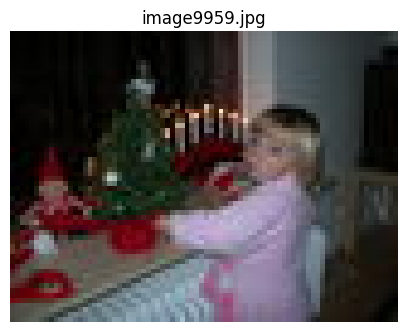

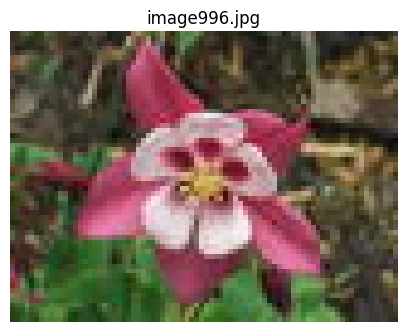

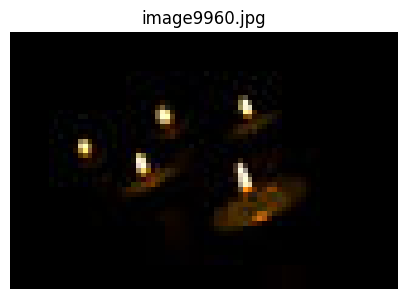

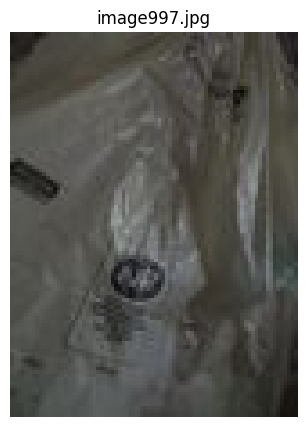

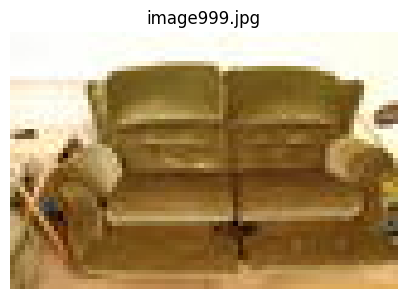

In [ ]:
negative_train_dir = "split_dataset/train/negative"
image_files = [f for f in os.listdir(negative_train_dir) if os.path.isfile(os.path.join(negative_train_dir, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))]

image_files.sort()

num_images_to_show = min(5, len(image_files)) # Display at most 5

last_image_files = image_files[-num_images_to_show:]

# Display the images
for filename in last_image_files:
    filepath = os.path.join(negative_train_dir, filename)
    try:
        img = Image.open(filepath)
        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.title(filename)
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Could not open or display image {filename}: {e}")

***augmentasi***

In [ ]:
!rm -rf split_dataset_augmented
import cv2
import numpy as np
import os
import random
from pathlib import Path
from tqdm import tqdm

# Configuration
input_root = "split_dataset/train"
output_root = "split_dataset_augmented/train"
augment_per_image = 1
overwrite_output = False  # Set to True to replace if needed

def random_augment(image):
    # Flip
    if random.random() < 0.5:
        image = cv2.flip(image, 1)  # horizontal flip
    # Rotate
    angle = random.uniform(-15, 15)
    h, w = image.shape[:2]
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1)
    image = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REFLECT)

    # Brightness / Contrast
    alpha = random.uniform(0.8, 1.2)
    beta = random.randint(-20, 20)
    image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

    # Add Gaussian noise
    if random.random() < 0.5:
        noise = np.random.normal(0, 10, image.shape).astype(np.uint8)
        image = cv2.add(image, noise)

    return image

def augment_folder(class_name):
    input_folder = Path(f"{input_root}/{class_name}")
    output_folder = Path(f"{output_root}/{class_name}")
    output_folder.mkdir(parents=True, exist_ok=True)

    image_files = list(input_folder.glob("*"))
    for img_path in tqdm(image_files, desc=f"Augmenting {class_name}"):
        img = cv2.imread(str(img_path))
        if img is None:
            continue

        # Save original if not already there
        if not overwrite_output:
            cv2.imwrite(str(output_folder / img_path.name), img)

        # Generate augmented versions
        for i in range(augment_per_image):
            aug_img = random_augment(img)
            aug_filename = img_path.stem + f"_aug{i}" + img_path.suffix
            cv2.imwrite(str(output_folder / aug_filename), aug_img)

augment_folder("positive")
augment_folder("negative")

print("✅ Augmentation complete! Saved to:", output_root)


Augmenting negative: 100%|██████████| 18000/18000 [00:50<00:00, 357.14it/s]

✅ Augmentation complete! Saved to: split_dataset_augmented/train


***Transform Pipeline***

In [ ]:
common_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# ***training***

In [ ]:
!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [ ]:
drive.mount('/content/drive')

drive_model_path = '/content/drive/MyDrive/concrete_crack_model_new.pth'

#earlystopping
class EarlyStopping:
    def __init__(self, patience, min_delta):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


# Define the number of output classes
num_classes = 2

#pretrained = because we want the model to distinguish outside wether its crack and no crack at all or just random object
model = timm.create_model("resnet18", pretrained=True, num_classes=num_classes)

# Check if GPU is available and move the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)


class ConcreteCrackDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {'positive': 1, 'negative': 0}

        for class_name, idx in self.class_to_idx.items():
            class_path = os.path.join(data_dir, class_name)

            if os.path.isdir(class_path):
                for img_name in os.listdir(class_path):
                    img_path = os.path.join(class_path, img_name)
                    # Check if it's a file before adding to paths
                    if os.path.isfile(img_path):
                         self.image_paths.append(img_path)
                         self.labels.append(idx)
            else:
                print(f"Warning: Directory not found: {class_path}")


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label


# Load full dataset
full_dataset = ConcreteCrackDataset(data_dir='split_dataset_augmented/train', transform = common_transform)

# Split train and val datasets (80% train, 20% val)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Parameters
batch_size = 32*2**5
num_classes = 2
num_epochs = 60
learning_rate = 5e-5  # or 3e-4 if you want to test slightly faster learning


# Data loaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
print("Starting training...")
scaler = GradScaler()
early_stopping = EarlyStopping(patience=4, min_delta=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):

        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        with autocast('cuda'):  # Mixed Precision
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
    # Inside your training loop
    if (epoch + 1) % 1 == 0:  # Save every epoch
        ckpt_path = f"/content/drive/MyDrive/crack_model_ckpt_epoch_{epoch+1}.pth"
        torch.save(model.state_dict(), ckpt_path)
        print(f"💾 Checkpoint saved at: {ckpt_path}")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, '/content/drive/MyDrive/crack_full_ckpt.pth')



    # Validation phase
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            with autocast('cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss = val_running_loss / len(val_dataset)
    val_accuracy = correct / total
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")

    # Early stopping and scheduler
    scheduler.step(val_loss)
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("✅ Early stopping triggered.")
        torch.save(model.state_dict(), drive_model_path)
        print(f"Model saved to Google Drive at {drive_model_path}")
        break

print("Training complete without early stopping.")

# Save model after training finished normally (if not early stopped)
if not early_stopping.early_stop:
  torch.save(model.state_dict(), drive_model_path)
  print(f"Model saved to Google Drive at {drive_model_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
<ipython-input-4-bd07322323a0>:99: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Starting training...


Epoch 1/60: 100%|██████████| 57/57 [03:56<00:00,  4.14s/it]


Epoch [1/60], Loss: 0.6564
💾 Checkpoint saved at: /content/drive/MyDrive/crack_model_ckpt_epoch_1.pth
Validation Loss: 0.6143, Accuracy: 0.5967


Epoch 2/60: 100%|██████████| 57/57 [03:54<00:00,  4.12s/it]


Epoch [2/60], Loss: 0.5698
💾 Checkpoint saved at: /content/drive/MyDrive/crack_model_ckpt_epoch_2.pth
Validation Loss: 0.5297, Accuracy: 0.7501


Epoch 3/60: 100%|██████████| 57/57 [03:54<00:00,  4.12s/it]


Epoch [3/60], Loss: 0.4841
💾 Checkpoint saved at: /content/drive/MyDrive/crack_model_ckpt_epoch_3.pth
Validation Loss: 0.4418, Accuracy: 0.8828


Epoch 4/60: 100%|██████████| 57/57 [03:54<00:00,  4.12s/it]


Epoch [4/60], Loss: 0.3997
💾 Checkpoint saved at: /content/drive/MyDrive/crack_model_ckpt_epoch_4.pth
Validation Loss: 0.3607, Accuracy: 0.9377


Epoch 5/60: 100%|██████████| 57/57 [03:55<00:00,  4.13s/it]


Epoch [5/60], Loss: 0.3194
💾 Checkpoint saved at: /content/drive/MyDrive/crack_model_ckpt_epoch_5.pth
Validation Loss: 0.2825, Accuracy: 0.9687


Epoch 6/60: 100%|██████████| 57/57 [03:55<00:00,  4.13s/it]


Epoch [6/60], Loss: 0.2442
💾 Checkpoint saved at: /content/drive/MyDrive/crack_model_ckpt_epoch_6.pth
Validation Loss: 0.2127, Accuracy: 0.9840


Epoch 7/60: 100%|██████████| 57/57 [03:53<00:00,  4.10s/it]


Epoch [7/60], Loss: 0.1769
💾 Checkpoint saved at: /content/drive/MyDrive/crack_model_ckpt_epoch_7.pth
Validation Loss: 0.1485, Accuracy: 0.9902


Epoch 8/60: 100%|██████████| 57/57 [03:53<00:00,  4.10s/it]


Epoch [8/60], Loss: 0.1196
💾 Checkpoint saved at: /content/drive/MyDrive/crack_model_ckpt_epoch_8.pth
Validation Loss: 0.0961, Accuracy: 0.9933


Epoch 9/60: 100%|██████████| 57/57 [03:54<00:00,  4.12s/it]


Epoch [9/60], Loss: 0.0767
💾 Checkpoint saved at: /content/drive/MyDrive/crack_model_ckpt_epoch_9.pth
Validation Loss: 0.0609, Accuracy: 0.9951


Epoch 10/60: 100%|██████████| 57/57 [03:54<00:00,  4.11s/it]


Epoch [10/60], Loss: 0.0483
💾 Checkpoint saved at: /content/drive/MyDrive/crack_model_ckpt_epoch_10.pth
Validation Loss: 0.0383, Accuracy: 0.9967


Epoch 11/60: 100%|██████████| 57/57 [03:53<00:00,  4.09s/it]


Epoch [11/60], Loss: 0.0308
💾 Checkpoint saved at: /content/drive/MyDrive/crack_model_ckpt_epoch_11.pth
Validation Loss: 0.0253, Accuracy: 0.9972


Epoch 12/60: 100%|██████████| 57/57 [03:54<00:00,  4.12s/it]


Epoch [12/60], Loss: 0.0206
💾 Checkpoint saved at: /content/drive/MyDrive/crack_model_ckpt_epoch_12.pth
Validation Loss: 0.0166, Accuracy: 0.9978


Epoch 13/60: 100%|██████████| 57/57 [03:54<00:00,  4.11s/it]


Epoch [13/60], Loss: 0.0145
💾 Checkpoint saved at: /content/drive/MyDrive/crack_model_ckpt_epoch_13.pth
Validation Loss: 0.0125, Accuracy: 0.9977


Epoch 14/60: 100%|██████████| 57/57 [03:52<00:00,  4.08s/it]


Epoch [14/60], Loss: 0.0110
💾 Checkpoint saved at: /content/drive/MyDrive/crack_model_ckpt_epoch_14.pth
Validation Loss: 0.0096, Accuracy: 0.9983


Epoch 15/60: 100%|██████████| 57/57 [03:53<00:00,  4.10s/it]


Epoch [15/60], Loss: 0.0086
💾 Checkpoint saved at: /content/drive/MyDrive/crack_model_ckpt_epoch_15.pth
Validation Loss: 0.0077, Accuracy: 0.9989


Epoch 16/60: 100%|██████████| 57/57 [03:54<00:00,  4.11s/it]


Epoch [16/60], Loss: 0.0070
💾 Checkpoint saved at: /content/drive/MyDrive/crack_model_ckpt_epoch_16.pth
Validation Loss: 0.0067, Accuracy: 0.9987


Epoch 17/60: 100%|██████████| 57/57 [03:52<00:00,  4.09s/it]


Epoch [17/60], Loss: 0.0057
💾 Checkpoint saved at: /content/drive/MyDrive/crack_model_ckpt_epoch_17.pth
Validation Loss: 0.0059, Accuracy: 0.9986


Epoch 18/60: 100%|██████████| 57/57 [03:52<00:00,  4.07s/it]


Epoch [18/60], Loss: 0.0049
💾 Checkpoint saved at: /content/drive/MyDrive/crack_model_ckpt_epoch_18.pth
Validation Loss: 0.0052, Accuracy: 0.9987


Epoch 19/60: 100%|██████████| 57/57 [03:54<00:00,  4.11s/it]


Epoch [19/60], Loss: 0.0041
💾 Checkpoint saved at: /content/drive/MyDrive/crack_model_ckpt_epoch_19.pth
Validation Loss: 0.0046, Accuracy: 0.9990


Epoch 20/60: 100%|██████████| 57/57 [03:53<00:00,  4.09s/it]


Epoch [20/60], Loss: 0.0036
💾 Checkpoint saved at: /content/drive/MyDrive/crack_model_ckpt_epoch_20.pth
Validation Loss: 0.0045, Accuracy: 0.9990


Epoch 21/60: 100%|██████████| 57/57 [03:52<00:00,  4.07s/it]


Epoch [21/60], Loss: 0.0032
💾 Checkpoint saved at: /content/drive/MyDrive/crack_model_ckpt_epoch_21.pth
Validation Loss: 0.0041, Accuracy: 0.9990


Epoch 22/60: 100%|██████████| 57/57 [03:54<00:00,  4.11s/it]


Epoch [22/60], Loss: 0.0029
💾 Checkpoint saved at: /content/drive/MyDrive/crack_model_ckpt_epoch_22.pth
Validation Loss: 0.0039, Accuracy: 0.9990


Epoch 23/60: 100%|██████████| 57/57 [03:53<00:00,  4.10s/it]


Epoch [23/60], Loss: 0.0025
💾 Checkpoint saved at: /content/drive/MyDrive/crack_model_ckpt_epoch_23.pth
Validation Loss: 0.0037, Accuracy: 0.9991
✅ Early stopping triggered.
Model saved to Google Drive at /content/drive/MyDrive/concrete_crack_model_new.pth
Training complete without early stopping.


***Final Testing***

batch, model di tes pada data yang berbeda dengan data training dan evaluasi sebelumnya

In [ ]:
# Load the final test dataset
test_dataset = ImageFolder(root='split_dataset/test', transform=common_transform)

# Create test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.load_state_dict(torch.load('/content/drive/MyDrive/concrete_crack_model_new.pth'))
model.to(device)
model.eval()

#initialization
correct = 0
total = 0
test_loss = 0.0

criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

avg_test_loss = test_loss / total
accuracy = correct / total

print(f"Final Test Loss: {avg_test_loss:.4f}")
print(f"Final Test Accuracy: {accuracy:.4f}")

Final Test Loss: 0.0037
Final Test Accuracy: 0.9990


single

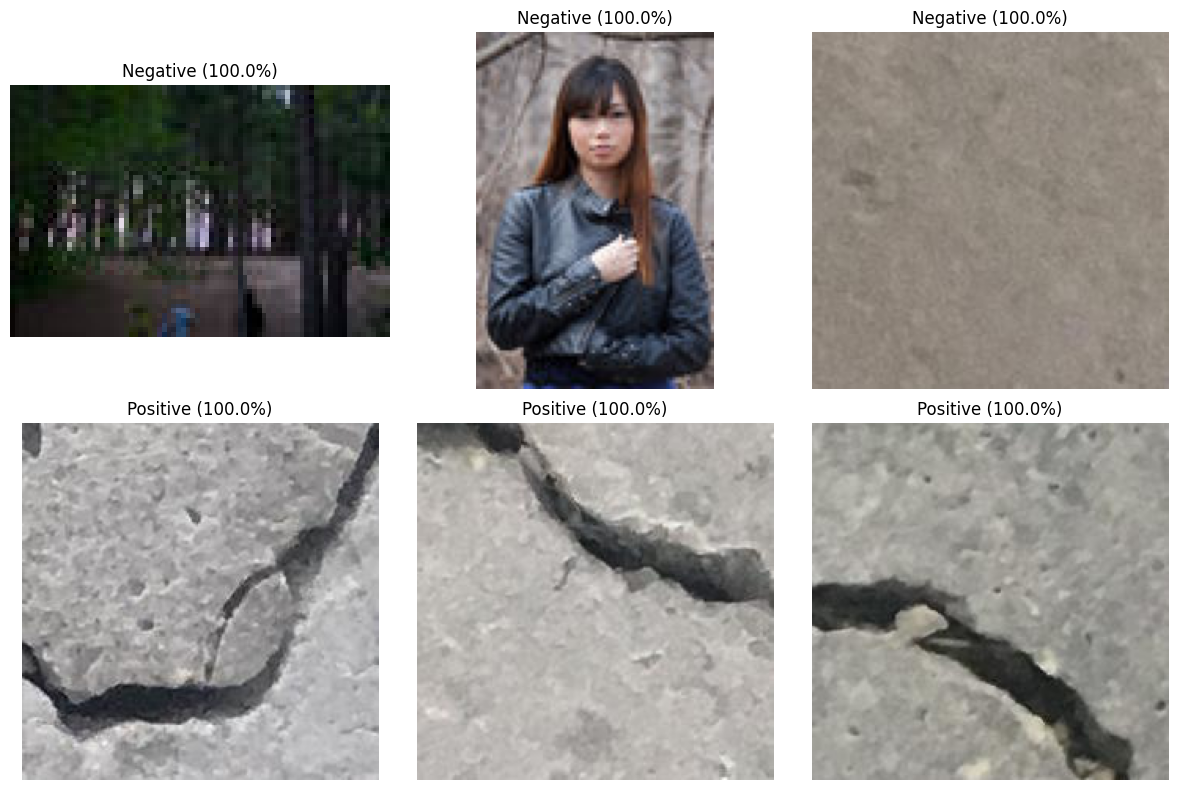

In [ ]:
def predict_single_image(model, image_path, transform, device):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(input_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probs, 1)
        predicted_class = "Positive" if predicted.item() == 1 else "Negative"
        return predicted_class, confidence.item(), image

def get_random_images_from_class(folder, n=3):
    all_images = os.listdir(folder)
    selected_images = random.sample(all_images, min(n, len(all_images)))
    return [os.path.join(folder, img) for img in selected_images]

neg_dir = 'split_dataset/test/negative'
pos_dir = 'split_dataset/test/positive'

neg_images = get_random_images_from_class(neg_dir, 3)
pos_images = get_random_images_from_class(pos_dir, 3)

selected_images = neg_images + pos_images

# Predict and plot
plt.figure(figsize=(12, 8))
for i, img_path in enumerate(selected_images):
    predicted_class, confidence, image = predict_single_image(model, img_path, common_transform, device)

    plt.subplot(2, 3, i+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"{predicted_class} ({confidence*100:.1f}%)")

plt.tight_layout()
plt.show()


# ***Heatmap wrapper : preprocessing and postprocessing***

In [ ]:
num_classes = 2
model = timm.create_model("resnet18", pretrained=True, num_classes=num_classes)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.load_state_dict(torch.load('/content/drive/MyDrive/concrete_crack_model_new.pth'))

model.to(device)

model.eval()

print("✅ Model loaded successfully and set to evaluation mode.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

✅ Model loaded successfully and set to evaluation mode.


in the making and test:

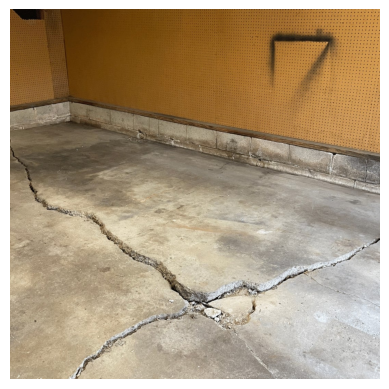

In [ ]:
img_rgb = cv2.cvtColor(cv2.imread('/content/garage-repair-westfield-before.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

***masking attemppt***

Predicting for category: object_oriented


100%|██████████| 16/16 [00:00<00:00, 139.88it/s]


Positive heatmap saved to positive_heatmap.png


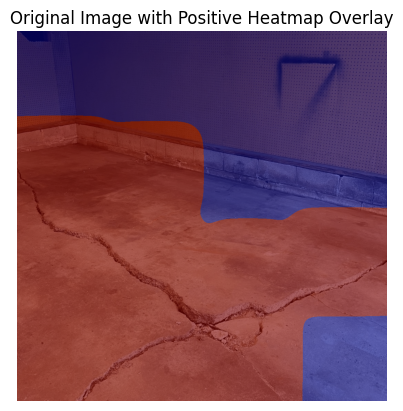

In [ ]:
def generate_positive_heatmap(predictions_list, original_shape, factor=15, confidence_threshold=0.4, output_path="positive_heatmap.png"):
    heatmap = np.zeros(original_shape, dtype=np.float32)

    for image_array, prediction_str, confidence, bbox_coords in predictions_list:
        if prediction_str == "Positive":
            if confidence > confidence_threshold: # Only consider predictions above the threshold
                x, y, w, h = bbox_coords

                # Scale size by factor * confidence
                scaled_w = int(w * factor * confidence)
                scaled_h = int(h * factor * confidence)

                # Center scaled hot spot around original crop center
                center_x = x + w // 2
                center_y = y + h // 2

                new_x1 = max(0, center_x - scaled_w // 2)
                new_y1 = max(0, center_y - scaled_h // 2)
                new_x2 = min(original_shape[1], center_x + scaled_w // 2)
                new_y2 = min(original_shape[0], center_y + scaled_h // 2)

                # Add a high value for confident predictions, otherwise 0 or a very small value
                # Using '1' for areas above threshold, and then normalizing will make them '1'
                heatmap[new_y1:new_y2, new_x1:new_x2] += 1.0 # Or any fixed high value, will be normalized

    # Normalize heatmap to 0-255. Areas with 0 contribution remain 0.
    # Areas with 1.0 contribution will become 255 (or similar high value) after normalization.
    if heatmap.max() > 0:
        heatmap_norm = cv2.normalize(heatmap, None, 0, 255, cv2.NORM_MINMAX)
    else:
        heatmap_norm = np.zeros_like(heatmap, dtype=np.float32)

    heatmap_blur = cv2.GaussianBlur(heatmap_norm, (0, 0), sigmaX=30, sigmaY=30, borderType=cv2.BORDER_DEFAULT)

    _, binary_heatmap = cv2.threshold(heatmap_blur, 50, 255, cv2.THRESH_BINARY)

    heatmap_colored = cv2.applyColorMap(binary_heatmap.astype(np.uint8), cv2.COLORMAP_JET)

    cv2.imwrite(output_path, heatmap_colored)
    print(f"Positive heatmap saved to {output_path}")
    return heatmap_colored

def overlay_heatmap_on_image(original_rgb, heatmap_colored, alpha=0.6):
    original_bgr = cv2.cvtColor(original_rgb, cv2.COLOR_RGB2BGR)
    if heatmap_colored.shape[:2] != original_bgr.shape[:2]:
        heatmap_colored = cv2.resize(heatmap_colored, (original_bgr.shape[1], original_bgr.shape[0]))
    overlay = cv2.addWeighted(heatmap_colored, alpha, original_bgr, 1 - alpha, 0)
    overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
    return overlay_rgb

def crop_tiles(image_rgb, tile_size, save_prefix="tile", save=False):
    tiles = []
    height, width, _ = image_rgb.shape
    tile_w, tile_h = tile_size

    for y in range(0, height, tile_h):
        for x in range(0, width, tile_w):
            end_x = min(x + tile_w, width)
            end_y = min(y + tile_h, height)

            tile = image_rgb[y:end_y, x:end_x]
            h_actual, w_actual, _ = tile.shape
            coords = (x, y, w_actual, h_actual)

            if w_actual < 5 or h_actual < 5:
                continue

            tiles.append((tile, coords))

            if save:
                cv2.imwrite(f"{save_prefix}_tile_{x}_{y}.png", tile)

    return {"object_oriented": tiles}

def predict_cropped_images(model, cropped_image_dict, transform, device):
    model.eval()
    predictions = {}

    for category, images_list_with_coords in cropped_image_dict.items():
        predictions[category] = []
        print(f"Predicting for category: {category}")
        for image_array, bbox_coords in tqdm(images_list_with_coords):
            image_pil = Image.fromarray(image_array)
            image_tensor = transform(image_pil).unsqueeze(0).to(device)

            with torch.no_grad():
                outputs = model(image_tensor)
                probs = F.softmax(outputs, dim=1)
                confidence = probs[0, 1].item()
                prediction = "Positive" if confidence > 0.7 else "Negative"
                predictions[category].append((image_array, prediction, confidence, bbox_coords))

    return predictions

d = 4

original_shape = img_rgb.shape[:2]
x = int(original_shape[0]/d)
y = int(original_shape[1]/d)

cropped_images = crop_tiles(img_rgb, tile_size=(x, y))

# 2. Run predict_cropped_images with the modified output
predictions = predict_cropped_images(model, cropped_image_dict=cropped_images, transform=common_transform, device=device)

# 3. Extract only the 'object_oriented' predictions, which now include bbox_coords
positive_predictions_for_heatmap = predictions['object_oriented']

# 4. Generate the new heatmap
heatmap_img = generate_positive_heatmap(positive_predictions_for_heatmap, original_shape, factor=1)

# 5. Overlay the heatmap
overlayed_img = overlay_heatmap_on_image(img_rgb, heatmap_img)
plt.imshow(overlayed_img)
plt.title("Original Image with Positive Heatmap Overlay")
plt.axis('off')
plt.show()

***Heatmapped***

Predicting for category: object_oriented


100%|██████████| 9/9 [00:00<00:00, 79.72it/s]


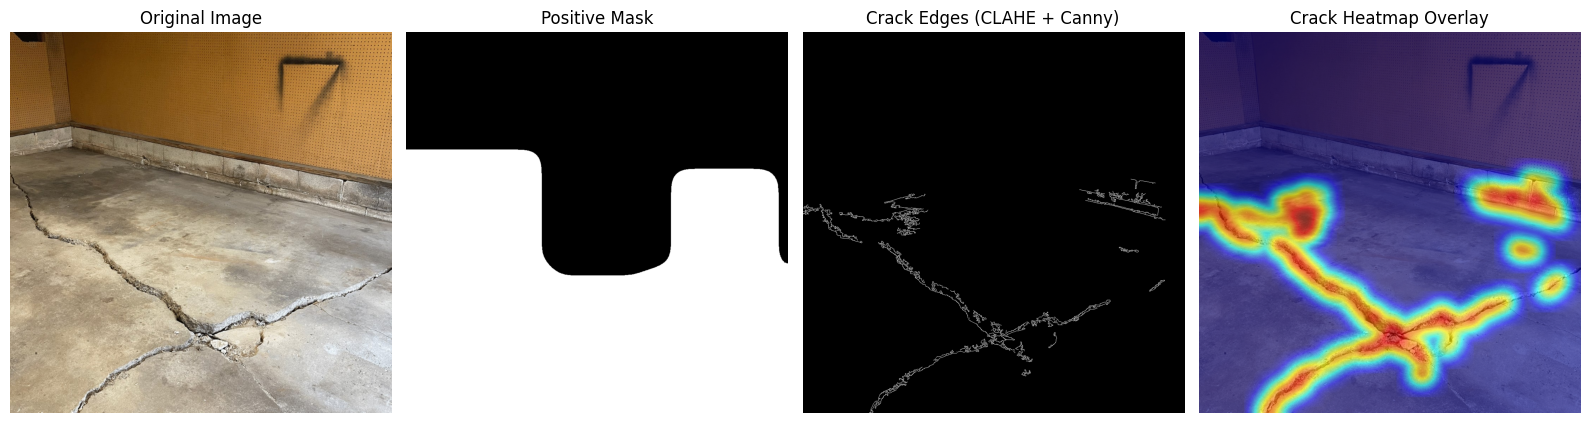

In [ ]:
def crop_tiles(image_rgb, tile_size, save_prefix="tile", save=False):
    tiles = []
    height, width, _ = image_rgb.shape
    tile_w, tile_h = tile_size

    for y in range(0, height, tile_h):
        for x in range(0, width, tile_w):
            end_x = min(x + tile_w, width)
            end_y = min(y + tile_h, height)

            tile = image_rgb[y:end_y, x:end_x]
            h_actual, w_actual, _ = tile.shape
            coords = (x, y, w_actual, h_actual)

            if w_actual < 5 or h_actual < 5:
                continue

            tiles.append((tile, coords))

            if save:
                cv2.imwrite(f"{save_prefix}_tile_{x}_{y}.png", tile)

    return {"object_oriented": tiles}

def predict_cropped_images(model, cropped_image_dict, transform, device):
    model.eval()
    predictions = {}

    for category, images_list_with_coords in cropped_image_dict.items():
        predictions[category] = []
        print(f"Predicting for category: {category}")
        for image_array, bbox_coords in tqdm(images_list_with_coords):
            image_pil = Image.fromarray(image_array)
            image_tensor = transform(image_pil).unsqueeze(0).to(device)

            with torch.no_grad():
                outputs = model(image_tensor)
                probs = F.softmax(outputs, dim=1)
                confidence = probs[0, 1].item()
                prediction = "Positive" if confidence > 0.7 else "Negative"
                predictions[category].append((image_array, prediction, confidence, bbox_coords))

    return predictions

# ---- Step 1: Generate binary mask from prediction results ----
def generate_positive_mask(predictions_list, original_shape, factor=15, confidence_threshold=0.7):
    heatmap = np.zeros(original_shape, dtype=np.float32)

    for image_array, prediction_str, confidence, bbox_coords in predictions_list:
        if prediction_str == "Positive" and confidence > confidence_threshold:
            x, y, w, h = bbox_coords
            scaled_w = int(w * factor * confidence)
            scaled_h = int(h * factor * confidence)
            center_x = x + w // 2
            center_y = y + h // 2
            new_x1 = max(0, center_x - scaled_w // 2)
            new_y1 = max(0, center_y - scaled_h // 2)
            new_x2 = min(original_shape[1], center_x + scaled_w // 2)
            new_y2 = min(original_shape[0], center_y + scaled_h // 2)
            heatmap[new_y1:new_y2, new_x1:new_x2] += 1.0

    heatmap_norm = cv2.normalize(heatmap, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    heatmap_blur = cv2.GaussianBlur(heatmap_norm, (0, 0), sigmaX=30, sigmaY=30)
    _, binary_mask = cv2.threshold(heatmap_blur, 50, 255, cv2.THRESH_BINARY)

    return binary_mask.astype(np.uint8)

# ---- Step 2: Better crack edge detection using CLAHE-enhanced binary region ----

def detect_cracks_within_mask(img_rgb, binary_mask, low_thresh=50, high_thresh=100, min_line_length=150):
    # Convert to grayscale
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    _, img_binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)

    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(img_binary)

    # Create gradient mask from binary mask edges
    dist_transform = cv2.distanceTransform(binary_mask, distanceType=cv2.DIST_L2, maskSize=5)
    dist_norm = cv2.normalize(dist_transform, None, alpha=0, beta=1.0, norm_type=cv2.NORM_MINMAX)
    gradient_mask = np.clip(dist_norm, 0, 1)

    clahe_float = clahe_img.astype(np.float32) / 255.0
    masked_enhanced = clahe_float * gradient_mask
    masked_enhanced_8u = np.uint8(masked_enhanced * 255)

    blurred = cv2.GaussianBlur(masked_enhanced_8u, (3, 3), sigmaX=0.5)
    edges = cv2.Canny(blurred, low_thresh, high_thresh)

    # ===== Post-process edges =====

    # 1. Remove small noise by finding contours and filtering by length
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    clean_edges = np.zeros_like(edges)

    for cnt in contours:
        if cv2.arcLength(cnt, False) >= min_line_length:
            cv2.drawContours(clean_edges, [cnt], -1, 255, thickness=1)

    # 2. Optional: Thin the edges using morphological thinning (skeletonization)
    clean_edges_thin = thinning(clean_edges)

    return clean_edges_thin

def thinning(src):
    """Apply morphological thinning to get 1-pixel wide lines."""
    # Using OpenCV's ximgproc thinning if available, else fallback to manual
    try:
        import cv2.ximgproc as ximgproc
        return ximgproc.thinning(src)
    except ImportError:
        # Simple manual thinning using morphological skeletonization
        return morphological_skeleton(src)

def morphological_skeleton(img):
    """Morphological skeletonization of a binary image."""
    size = np.size(img)
    skel = np.zeros(img.shape, np.uint8)

    element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
    done = False

    img_bin = img.copy()
    while(not done):
        eroded = cv2.erode(img_bin, element)
        temp = cv2.dilate(eroded, element)
        temp = cv2.subtract(img_bin, temp)
        skel = cv2.bitwise_or(skel, temp)
        img_bin = eroded.copy()

        zeros = size - cv2.countNonZero(img_bin)
        if zeros == size:
            done = True
    return skel


# ---- Step 3: Convert crack edges to smooth heatmap ----
def crack_edges_to_heatmap(crack_edges, intensity_factor=10, gamma=0.25):
    amplified = np.clip(crack_edges.astype(np.float32) * intensity_factor, 0, 255)
    heatmap = cv2.GaussianBlur(amplified, (0, 0), sigmaX=15, sigmaY=15)
    heatmap = np.power(heatmap / 255.0, gamma) * 255.0

    heatmap_norm = cv2.normalize(heatmap, None, 0, 255, cv2.NORM_MINMAX)
    heatmap_colored = cv2.applyColorMap(heatmap_norm.astype(np.uint8), cv2.COLORMAP_JET)
    return heatmap_colored


# ---- Step 4: Overlay heatmap on original image ----
def overlay_heatmap_on_image(original_rgb, heatmap_colored, alpha=0.6):
    original_bgr = cv2.cvtColor(original_rgb, cv2.COLOR_RGB2BGR)
    if heatmap_colored.shape[:2] != original_bgr.shape[:2]:
        heatmap_colored = cv2.resize(heatmap_colored, (original_bgr.shape[1], original_bgr.shape[0]))
    overlay = cv2.addWeighted(heatmap_colored, alpha, original_bgr, 1 - alpha, 0)
    overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
    return overlay_rgb

d = 3

original_shape = img_rgb.shape[:2]
x = int(original_shape[0]/d)
y = int(original_shape[1]/d)

cropped_images = crop_tiles(img_rgb, tile_size=(x, y))

# 2. Run predict_cropped_images with the modified output
predictions = predict_cropped_images(model, cropped_image_dict=cropped_images, transform=common_transform, device=device)

# 3. Extract only the 'object_oriented' predictions, which now include bbox_coords
positive_predictions_for_heatmap = predictions['object_oriented']

# 1. Get binary mask from predictions
binary_mask = generate_positive_mask(positive_predictions_for_heatmap, img_rgb.shape[:2], factor=1.2)

# 2. Detect cracks using binary-masked CLAHE
crack_edges = detect_cracks_within_mask(img_rgb, binary_mask)

# 3. Make heatmap from crack edges
crack_heatmap = crack_edges_to_heatmap(crack_edges)

# 4. Overlay on original
overlayed_crack_img = overlay_heatmap_on_image(img_rgb, crack_heatmap, alpha=0.6)

# 5. Display result
plt.figure(figsize=(16, 6))

plt.subplot(1, 4, 1)
plt.imshow(img_rgb)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(binary_mask, cmap='gray')
plt.title("Positive Mask")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(crack_edges, cmap='gray')
plt.title("Crack Edges (CLAHE + Canny)")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(overlayed_crack_img)
plt.title("Crack Heatmap Overlay")
plt.axis('off')

plt.tight_layout()
plt.show()


# ***Future Work***

***vedo2frame -> heatmap -> frame2video***


In [ ]:
#function dependency
def crop_tiles(image_rgb, tile_size, save_prefix="tile", save=False):
    tiles = []
    height, width, _ = image_rgb.shape
    tile_w, tile_h = tile_size

    for y in range(0, height, tile_h):
        for x in range(0, width, tile_w):
            end_x = min(x + tile_w, width)
            end_y = min(y + tile_h, height)

            tile = image_rgb[y:end_y, x:end_x]
            h_actual, w_actual, _ = tile.shape
            coords = (x, y, w_actual, h_actual)

            if w_actual < 5 or h_actual < 5:
                continue

            tiles.append((tile, coords))

            if save:
                cv2.imwrite(f"{save_prefix}_tile_{x}_{y}.png", tile)

    return {"object_oriented": tiles}

def predict_cropped_images(model, cropped_image_dict, transform, device):
    model.eval()
    predictions = {}

    for category, images_list_with_coords in cropped_image_dict.items():
        predictions[category] = []
        print(f"Predicting for category: {category}")
        for image_array, bbox_coords in tqdm(images_list_with_coords):
            image_pil = Image.fromarray(image_array)
            image_tensor = transform(image_pil).unsqueeze(0).to(device)

            with torch.no_grad():
                outputs = model(image_tensor)
                probs = F.softmax(outputs, dim=1)
                confidence = probs[0, 1].item()
                prediction = "Positive" if confidence > 0.7 else "Negative"
                predictions[category].append((image_array, prediction, confidence, bbox_coords))

    return predictions

def generate_positive_mask(predictions_list, original_shape, factor=15, confidence_threshold=0.7):
    heatmap = np.zeros(original_shape, dtype=np.float32)

    for image_array, prediction_str, confidence, bbox_coords in predictions_list:
        if prediction_str == "Positive" and confidence > confidence_threshold:
            x, y, w, h = bbox_coords
            scaled_w = int(w * factor * confidence)
            scaled_h = int(h * factor * confidence)
            center_x = x + w // 2
            center_y = y + h // 2
            new_x1 = max(0, center_x - scaled_w // 2)
            new_y1 = max(0, center_y - scaled_h // 2)
            new_x2 = min(original_shape[1], center_x + scaled_w // 2)
            new_y2 = min(original_shape[0], center_y + scaled_h // 2)
            heatmap[new_y1:new_y2, new_x1:new_x2] += 1.0

    heatmap_norm = cv2.normalize(heatmap, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    heatmap_blur = cv2.GaussianBlur(heatmap_norm, (0, 0), sigmaX=30, sigmaY=30)
    _, binary_mask = cv2.threshold(heatmap_blur, 50, 255, cv2.THRESH_BINARY)

    return binary_mask.astype(np.uint8)

def detect_cracks_within_mask(img_rgb, binary_mask, low_thresh=50, high_thresh=100, min_line_length=150):
    # Convert to grayscale
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    _, img_binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)

    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(img_binary)

    dist_transform = cv2.distanceTransform(binary_mask, distanceType=cv2.DIST_L2, maskSize=5)
    dist_norm = cv2.normalize(dist_transform, None, alpha=0, beta=1.0, norm_type=cv2.NORM_MINMAX)
    gradient_mask = np.clip(dist_norm, 0, 1)

    clahe_float = clahe_img.astype(np.float32) / 255.0
    masked_enhanced = clahe_float * gradient_mask
    masked_enhanced_8u = np.uint8(masked_enhanced * 255)

    blurred = cv2.GaussianBlur(masked_enhanced_8u, (3, 3), sigmaX=0.5)
    edges = cv2.Canny(blurred, low_thresh, high_thresh)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    clean_edges = np.zeros_like(edges)

    for cnt in contours:
        if cv2.arcLength(cnt, False) >= min_line_length:
            cv2.drawContours(clean_edges, [cnt], -1, 255, thickness=1)
    clean_edges_thin = thinning(clean_edges)

    return clean_edges_thin

def thinning(src):
    try:
        import cv2.ximgproc as ximgproc
        return ximgproc.thinning(src)
    except ImportError:
        return morphological_skeleton(src)

def morphological_skeleton(img):
    size = np.size(img)
    skel = np.zeros(img.shape, np.uint8)

    element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
    done = False

    img_bin = img.copy()
    while(not done):
        eroded = cv2.erode(img_bin, element)
        temp = cv2.dilate(eroded, element)
        temp = cv2.subtract(img_bin, temp)
        skel = cv2.bitwise_or(skel, temp)
        img_bin = eroded.copy()

        zeros = size - cv2.countNonZero(img_bin)
        if zeros == size:
            done = True
    return skel

def crack_edges_to_heatmap(crack_edges, intensity_factor=10, gamma=0.25):
    amplified = np.clip(crack_edges.astype(np.float32) * intensity_factor, 0, 255)
    heatmap = cv2.GaussianBlur(amplified, (0, 0), sigmaX=15, sigmaY=15)
    heatmap = np.power(heatmap / 255.0, gamma) * 255.0

    heatmap_norm = cv2.normalize(heatmap, None, 0, 255, cv2.NORM_MINMAX)
    heatmap_colored = cv2.applyColorMap(heatmap_norm.astype(np.uint8), cv2.COLORMAP_JET)
    return heatmap_colored

def overlay_heatmap_on_image(original_rgb, heatmap_colored, alpha=0.6):
    original_bgr = cv2.cvtColor(original_rgb, cv2.COLOR_RGB2BGR)
    if heatmap_colored.shape[:2] != original_bgr.shape[:2]:
        heatmap_colored = cv2.resize(heatmap_colored, (original_bgr.shape[1], original_bgr.shape[0]))
    overlay = cv2.addWeighted(heatmap_colored, alpha, original_bgr, 1 - alpha, 0)
    overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
    return overlay_rgb


In [ ]:
def picture2heatmap(picture,d,):
  img_rgb = cv2.cvtColor(cv2.imread(picture), cv2.COLOR_BGR2RGB)
  original_shape = img_rgb.shape[:2]
  x = int(original_shape[0]/d)
  y = int(original_shape[1]/d)
  cropped_images = crop_tiles(img_rgb, tile_size=(x, y))
  predictions = predict_cropped_images(model, cropped_image_dict=cropped_images, transform=common_transform, device=device)
  positive_predictions_for_heatmap = predictions['object_oriented']
  binary_mask = generate_positive_mask(positive_predictions_for_heatmap, img_rgb.shape[:2], factor=1.2)
  crack_edges = detect_cracks_within_mask(img_rgb, binary_mask,80)
  crack_heatmap = crack_edges_to_heatmap(crack_edges)
  overlayed_crack_img = overlay_heatmap_on_image(img_rgb, crack_heatmap, alpha=0.6)
  return overlayed_crack_img


In [ ]:
#function dependency
def crop_tiles(image_rgb, tile_size, save_prefix="tile", save=False):
    tiles = []
    height, width, _ = image_rgb.shape
    tile_w, tile_h = tile_size

    for y in range(0, height, tile_h):
        for x in range(0, width, tile_w):
            end_x = min(x + tile_w, width)
            end_y = min(y + tile_h, height)

            tile = image_rgb[y:end_y, x:end_x]
            h_actual, w_actual, _ = tile.shape
            coords = (x, y, w_actual, h_actual)

            if w_actual < 5 or h_actual < 5:
                continue

            tiles.append((tile, coords))

            if save:
                cv2.imwrite(f"{save_prefix}_tile_{x}_{y}.png", tile)

    return {"object_oriented": tiles}

def predict_cropped_images(model, cropped_image_dict, transform, device):
    model.eval()
    predictions = {}

    for category, images_list_with_coords in cropped_image_dict.items():
        predictions[category] = []
        print(f"Predicting for category: {category}")
        for image_array, bbox_coords in tqdm(images_list_with_coords):
            image_pil = Image.fromarray(image_array)
            image_tensor = transform(image_pil).unsqueeze(0).to(device)

            with torch.no_grad():
                outputs = model(image_tensor)
                probs = F.softmax(outputs, dim=1)
                confidence = probs[0, 1].item()
                prediction = "Positive" if confidence > 0.7 else "Negative"
                predictions[category].append((image_array, prediction, confidence, bbox_coords))

    return predictions

def generate_positive_mask(predictions_list, original_shape, factor=15, confidence_threshold=0.75):
    heatmap = np.zeros(original_shape, dtype=np.float32)

    for image_array, prediction_str, confidence, bbox_coords in predictions_list:
        if prediction_str == "Positive" and confidence > confidence_threshold:
            x, y, w, h = bbox_coords
            scaled_w = int(w * factor * confidence)
            scaled_h = int(h * factor * confidence)
            center_x = x + w // 2
            center_y = y + h // 2
            new_x1 = max(0, center_x - scaled_w // 2)
            new_y1 = max(0, center_y - scaled_h // 2)
            new_x2 = min(original_shape[1], center_x + scaled_w // 2)
            new_y2 = min(original_shape[0], center_y + scaled_h // 2)
            heatmap[new_y1:new_y2, new_x1:new_x2] += 1.0

    heatmap_norm = cv2.normalize(heatmap, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    heatmap_blur = cv2.GaussianBlur(heatmap_norm, (0, 0), sigmaX=30, sigmaY=30)
    _, binary_mask = cv2.threshold(heatmap_blur, 50, 255, cv2.THRESH_BINARY)

    return binary_mask.astype(np.uint8)

def detect_cracks_within_mask(img_rgb, binary_mask, low_thresh=50, high_thresh=100, min_line_length):
    # Convert to grayscale
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    _, img_binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)

    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(img_binary)

    dist_transform = cv2.distanceTransform(binary_mask, distanceType=cv2.DIST_L2, maskSize=5)
    dist_norm = cv2.normalize(dist_transform, None, alpha=0, beta=1.0, norm_type=cv2.NORM_MINMAX)
    gradient_mask = np.clip(dist_norm, 0, 1)

    clahe_float = clahe_img.astype(np.float32) / 255.0
    masked_enhanced = clahe_float * gradient_mask
    masked_enhanced_8u = np.uint8(masked_enhanced * 255)

    blurred = cv2.GaussianBlur(masked_enhanced_8u, (3, 3), sigmaX=0.5)
    edges = cv2.Canny(blurred, low_thresh, high_thresh)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    clean_edges = np.zeros_like(edges)

    for cnt in contours:
        if cv2.arcLength(cnt, False) >= min_line_length:
            cv2.drawContours(clean_edges, [cnt], -1, 255, thickness=1)
    clean_edges_thin = thinning(clean_edges)

    return clean_edges_thin

def thinning(src):
    try:
        import cv2.ximgproc as ximgproc
        return ximgproc.thinning(src)
    except ImportError:
        return morphological_skeleton(src)

def morphological_skeleton(img):
    size = np.size(img)
    skel = np.zeros(img.shape, np.uint8)

    element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
    done = False

    img_bin = img.copy()
    while(not done):
        eroded = cv2.erode(img_bin, element)
        temp = cv2.dilate(eroded, element)
        temp = cv2.subtract(img_bin, temp)
        skel = cv2.bitwise_or(skel, temp)
        img_bin = eroded.copy()

        zeros = size - cv2.countNonZero(img_bin)
        if zeros == size:
            done = True
    return skel

def crack_edges_to_heatmap(crack_edges, intensity_factor=10, gamma=0.25):
    amplified = np.clip(crack_edges.astype(np.float32) * intensity_factor, 0, 255)
    heatmap = cv2.GaussianBlur(amplified, (0, 0), sigmaX=15, sigmaY=15)
    heatmap = np.power(heatmap / 255.0, gamma) * 255.0

    heatmap_norm = cv2.normalize(heatmap, None, 0, 255, cv2.NORM_MINMAX)
    heatmap_colored = cv2.applyColorMap(heatmap_norm.astype(np.uint8), cv2.COLORMAP_JET)
    return heatmap_colored

def overlay_heatmap_on_image(original_rgb, heatmap_colored, alpha=0.6):
    original_bgr = cv2.cvtColor(original_rgb, cv2.COLOR_RGB2BGR)
    if heatmap_colored.shape[:2] != original_bgr.shape[:2]:
        heatmap_colored = cv2.resize(heatmap_colored, (original_bgr.shape[1], original_bgr.shape[0]))
    overlay = cv2.addWeighted(heatmap_colored, alpha, original_bgr, 1 - alpha, 0)
    overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
    return overlay_rgb

# %%
def picture2heatmap(picture_path, d):
  img_rgb = cv2.cvtColor(cv2.imread(picture_path), cv2.COLOR_BGR2RGB)
  original_shape = img_rgb.shape[:2]
  x = int(original_shape[0]/d)
  y = int(original_shape[1]/d)
  cropped_images = crop_tiles(img_rgb, tile_size=(x, y))
  predictions = predict_cropped_images(model, cropped_image_dict=cropped_images, transform=common_transform, device=device)
  positive_predictions_for_heatmap = predictions['object_oriented']
  binary_mask = generate_positive_mask(positive_predictions_for_heatmap, img_rgb.shape[:2], factor=1.5)
  crack_edges = detect_cracks_within_mask(img_rgb, binary_mask)
  crack_heatmap = crack_edges_to_heatmap(crack_edges)
  overlayed_crack_img = overlay_heatmap_on_image(img_rgb, crack_heatmap, alpha=0.6)
  return overlayed_crack_img

# %%
# --- Step 1: Extract frames from video ---
def extract_frames(video_path, output_folder="frames"):
    os.makedirs(output_folder, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    frame_count = 0

    while True:
        success, frame = cap.read()
        if not success:
            break
        cv2.imwrite(f"{output_folder}/frame_{frame_count:05d}.png", frame)
        frame_count += 1

    cap.release()
    print(f"Extracted {frame_count} frames.")
    return frame_count # Return the number of frames

# --- Step 2: Process each extracted frame ---
def process_frames(input_folder="frames", output_folder="processed_frames"):
    os.makedirs(output_folder, exist_ok=True)
    filenames = sorted(os.listdir(input_folder))

    for name in tqdm(filenames, desc="Processing frames"):
        frame_path = os.path.join(input_folder, name)
        # Pass the file path to picture2heatmap
        heatmapped_rgb = picture2heatmap(frame_path, 6)
        if heatmapped_rgb is not None: # Only proceed if picture2heatmap returned an image
          # Convert the processed image back to BGR for saving with cv2
          heatmapped_bgr = cv2.cvtColor(heatmapped_rgb, cv2.COLOR_RGB2BGR)
          cv2.imwrite(os.path.join(output_folder, name), heatmapped_bgr)


# --- Step 3: Reassemble frames back into a video ---
def frames_to_video(input_folder="processed_frames", output_path="output_video.mp4", fps=30):
    filenames = sorted(os.listdir(input_folder))
    if not filenames:
      print("No frames to process.")
      return

    first_frame_path = os.path.join(input_folder, filenames[0])
    first_frame = cv2.imread(first_frame_path)
    if first_frame is None:
        print(f"Could not read the first frame: {first_frame_path}")
        return

    height, width = first_frame.shape[:2]
    # Check if the first frame is color (3 channels) or grayscale (2 channels)
    is_color = len(first_frame.shape) == 3

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    # Set isColor based on the first frame
    writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height), isColor=is_color)

    for name in tqdm(filenames, desc="Writing video"):
        frame = cv2.imread(os.path.join(input_folder, name))
        if frame is None:
          continue
        # Ensure the frame has 3 channels before writing if the writer expects color
        if is_color and len(frame.shape) == 2:
            frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
        # Ensure the frame has only 1 channel if the writer expects grayscale
        elif not is_color and len(frame.shape) == 3:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        writer.write(frame)

    writer.release()
    print(f"Video saved to {output_path}")

def get_video_fps(video_path):
    """Detects or calculates the FPS of a video."""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video file.")
        return None

    # Attempt to get FPS directly from the video file metadata
    fps = cap.get(cv2.CAP_PROP_FPS)

    if fps > 0:
        cap.release()
        return fps
    else:
        # If direct reading fails, try to get frame count and duration (less reliable)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        # You might need a more robust way to get duration if FPS is not available
        # For simplicity here, we'll just return a default if FPS is not found
        cap.release()
        print("Warning: Could not get FPS directly. Returning default 30 FPS.")
        return 30.0 # Return a default value

# Example usage:
video_path = "/content/vecteezy_a-close-up-of-a-cracked-concrete-floor_50022880.mp4" # Replace with your video path

# --- Main workflow ---
# Ensure frame directories are clean
!rm -rf frames processed_frames

# Step 1: Extract frames
extract_frames(video_path, output_folder="frames")

# Step 2: Process frames
process_frames(input_folder="frames", output_folder="processed_frames")

# Step 3: Get video FPS (to maintain original speed)
video_fps = get_video_fps(video_path)

# Step 4: Reassemble into video
if video_fps is not None:
  print(f"Detected video FPS: {video_fps}")
  frames_to_video(input_folder="processed_frames", output_path="output_video.mp4", fps=video_fps)
else:
  # Use a default FPS if detection fails
  frames_to_video(input_folder="processed_frames", output_path="output_video.mp4", fps=30)

Extracted 195 frames.


Processing frames:   0%|          | 0/195 [00:00<?, ?it/s]

Predicting for category: object_oriented



Processing frames:   1%|          | 1/195 [00:02<09:30,  2.94s/it]

Predicting for category: object_oriented



Processing frames:   1%|          | 2/195 [00:05<08:44,  2.72s/it]

Predicting for category: object_oriented



Processing frames:   2%|▏         | 3/195 [00:08<08:36,  2.69s/it]

Predicting for category: object_oriented



Processing frames:   2%|▏         | 4/195 [00:10<08:33,  2.69s/it]

Predicting for category: object_oriented



Processing frames:   3%|▎         | 5/195 [00:14<09:46,  3.09s/it]

Predicting for category: object_oriented



Processing frames:   3%|▎         | 6/195 [00:17<09:14,  2.94s/it]

Predicting for category: object_oriented



Processing frames:   4%|▎         | 7/195 [00:19<08:53,  2.84s/it]

Predicting for category: object_oriented



Processing frames:   4%|▍         | 8/195 [00:22<08:39,  2.78s/it]

Predicting for category: object_oriented



Processing frames:   5%|▍         | 9/195 [00:25<09:12,  2.97s/it]

Predicting for category: object_oriented



Processing frames:   5%|▌         | 10/195 [00:29<09:15,  3.00s/it]

Predicting for category: object_oriented



Processing frames:   6%|▌         | 11/195 [00:31<08:47,  2.87s/it]

Predicting for category: object_oriented



Processing frames:   6%|▌         | 12/195 [00:34<08:39,  2.84s/it]

Predicting for category: object_oriented



Processing frames:   7%|▋         | 13/195 [00:37<08:44,  2.88s/it]

Predicting for category: object_oriented



Processing frames:   7%|▋         | 14/195 [00:41<09:32,  3.17s/it]

Predicting for category: object_oriented



Processing frames:   8%|▊         | 15/195 [00:43<09:06,  3.04s/it]

Predicting for category: object_oriented



Processing frames:   8%|▊         | 16/195 [00:46<08:50,  2.96s/it]

Predicting for category: object_oriented



Processing frames:   9%|▊         | 17/195 [00:49<08:36,  2.90s/it]

Predicting for category: object_oriented



Processing frames:   9%|▉         | 18/195 [00:52<08:53,  3.01s/it]

Predicting for category: object_oriented



Processing frames:  10%|▉         | 19/195 [00:55<09:01,  3.08s/it]

Predicting for category: object_oriented



Processing frames:  10%|█         | 20/195 [00:58<08:41,  2.98s/it]

Predicting for category: object_oriented



Processing frames:  11%|█         | 21/195 [01:01<08:22,  2.89s/it]

Predicting for category: object_oriented



Processing frames:  11%|█▏        | 22/195 [01:04<08:11,  2.84s/it]

Predicting for category: object_oriented



Processing frames:  12%|█▏        | 23/195 [01:08<09:07,  3.18s/it]

Predicting for category: object_oriented



Processing frames:  12%|█▏        | 24/195 [01:10<08:38,  3.03s/it]

Predicting for category: object_oriented



Processing frames:  13%|█▎        | 25/195 [01:13<08:22,  2.96s/it]

Predicting for category: object_oriented



Processing frames:  13%|█▎        | 26/195 [01:16<08:09,  2.90s/it]

Predicting for category: object_oriented



Processing frames:  14%|█▍        | 27/195 [01:19<08:25,  3.01s/it]

Predicting for category: object_oriented



Processing frames:  14%|█▍        | 28/195 [01:22<08:35,  3.09s/it]

Predicting for category: object_oriented



Processing frames:  15%|█▍        | 29/195 [01:25<08:16,  2.99s/it]

Predicting for category: object_oriented



Processing frames:  15%|█▌        | 30/195 [01:28<08:02,  2.92s/it]

Predicting for category: object_oriented



Processing frames:  16%|█▌        | 31/195 [01:31<08:00,  2.93s/it]

Predicting for category: object_oriented



Processing frames:  16%|█▋        | 32/195 [01:35<08:52,  3.27s/it]

Predicting for category: object_oriented



Processing frames:  17%|█▋        | 33/195 [01:38<08:33,  3.17s/it]

Predicting for category: object_oriented



Processing frames:  17%|█▋        | 34/195 [01:41<08:19,  3.10s/it]

Predicting for category: object_oriented



Processing frames:  18%|█▊        | 35/195 [01:44<07:58,  2.99s/it]

Predicting for category: object_oriented



Processing frames:  18%|█▊        | 36/195 [01:47<08:35,  3.24s/it]

Predicting for category: object_oriented



Processing frames:  19%|█▉        | 37/195 [01:51<08:38,  3.28s/it]

Predicting for category: object_oriented



Processing frames:  19%|█▉        | 38/195 [01:54<08:14,  3.15s/it]

Predicting for category: object_oriented



Processing frames:  20%|██        | 39/195 [01:56<07:54,  3.04s/it]

Predicting for category: object_oriented



Processing frames:  21%|██        | 40/195 [02:00<08:00,  3.10s/it]

Predicting for category: object_oriented



Processing frames:  21%|██        | 41/195 [02:03<08:14,  3.21s/it]

Predicting for category: object_oriented



Processing frames:  22%|██▏       | 42/195 [02:06<07:52,  3.09s/it]

Predicting for category: object_oriented



Processing frames:  22%|██▏       | 43/195 [02:08<07:27,  2.94s/it]

Predicting for category: object_oriented



Processing frames:  23%|██▎       | 44/195 [02:11<07:24,  2.94s/it]

Predicting for category: object_oriented



Processing frames:  23%|██▎       | 45/195 [02:15<08:06,  3.24s/it]

Predicting for category: object_oriented



Processing frames:  24%|██▎       | 46/195 [02:18<07:50,  3.16s/it]

Predicting for category: object_oriented



Processing frames:  24%|██▍       | 47/195 [02:21<07:26,  3.02s/it]

Predicting for category: object_oriented



Processing frames:  25%|██▍       | 48/195 [02:24<07:17,  2.98s/it]

Predicting for category: object_oriented



Processing frames:  25%|██▌       | 49/195 [02:28<07:51,  3.23s/it]

Predicting for category: object_oriented



Processing frames:  26%|██▌       | 50/195 [02:31<07:39,  3.17s/it]

Predicting for category: object_oriented



Processing frames:  26%|██▌       | 51/195 [02:33<07:15,  3.02s/it]

Predicting for category: object_oriented



Processing frames:  27%|██▋       | 52/195 [02:36<06:58,  2.93s/it]

Predicting for category: object_oriented



Processing frames:  27%|██▋       | 53/195 [02:39<07:02,  2.97s/it]

Predicting for category: object_oriented



Processing frames:  28%|██▊       | 54/195 [02:43<07:25,  3.16s/it]

Predicting for category: object_oriented



Processing frames:  28%|██▊       | 55/195 [02:46<07:06,  3.05s/it]

Predicting for category: object_oriented



Processing frames:  29%|██▊       | 56/195 [02:48<06:49,  2.95s/it]

Predicting for category: object_oriented



Processing frames:  29%|██▉       | 57/195 [02:51<06:40,  2.90s/it]

Predicting for category: object_oriented



Processing frames:  30%|██▉       | 58/195 [02:55<07:19,  3.21s/it]

Predicting for category: object_oriented



Processing frames:  30%|███       | 59/195 [02:58<07:04,  3.12s/it]

Predicting for category: object_oriented



Processing frames:  31%|███       | 60/195 [03:01<06:40,  2.97s/it]

Predicting for category: object_oriented



Processing frames:  31%|███▏      | 61/195 [03:03<06:26,  2.89s/it]

Predicting for category: object_oriented



Processing frames:  32%|███▏      | 62/195 [03:06<06:24,  2.89s/it]

Predicting for category: object_oriented



Processing frames:  32%|███▏      | 63/195 [03:10<06:50,  3.11s/it]

Predicting for category: object_oriented



Processing frames:  33%|███▎      | 64/195 [03:13<06:34,  3.01s/it]

Predicting for category: object_oriented



Processing frames:  33%|███▎      | 65/195 [03:15<06:28,  2.99s/it]

Predicting for category: object_oriented



Processing frames:  34%|███▍      | 66/195 [03:18<06:17,  2.93s/it]

Predicting for category: object_oriented



Processing frames:  34%|███▍      | 67/195 [03:22<06:41,  3.14s/it]

Predicting for category: object_oriented



Processing frames:  35%|███▍      | 68/195 [03:25<06:27,  3.05s/it]

Predicting for category: object_oriented



Processing frames:  35%|███▌      | 69/195 [03:28<06:20,  3.02s/it]

Predicting for category: object_oriented



Processing frames:  36%|███▌      | 70/195 [03:31<06:14,  3.00s/it]

Predicting for category: object_oriented



Processing frames:  36%|███▋      | 71/195 [03:34<06:12,  3.01s/it]

Predicting for category: object_oriented



Processing frames:  37%|███▋      | 72/195 [03:37<06:31,  3.19s/it]

Predicting for category: object_oriented



Processing frames:  37%|███▋      | 73/195 [03:40<06:11,  3.05s/it]

Predicting for category: object_oriented



Processing frames:  38%|███▊      | 74/195 [03:43<06:02,  2.99s/it]

Predicting for category: object_oriented



Processing frames:  38%|███▊      | 75/195 [03:46<05:53,  2.94s/it]

Predicting for category: object_oriented



Processing frames:  39%|███▉      | 76/195 [03:50<06:37,  3.34s/it]

Predicting for category: object_oriented



Processing frames:  39%|███▉      | 77/195 [03:53<06:12,  3.16s/it]

Predicting for category: object_oriented



Processing frames:  40%|████      | 78/195 [03:55<05:55,  3.04s/it]

Predicting for category: object_oriented



Processing frames:  41%|████      | 79/195 [03:58<05:37,  2.91s/it]

Predicting for category: object_oriented



Processing frames:  41%|████      | 80/195 [04:01<05:35,  2.92s/it]

Predicting for category: object_oriented



Processing frames:  42%|████▏     | 81/195 [04:04<05:52,  3.09s/it]

Predicting for category: object_oriented



Processing frames:  42%|████▏     | 82/195 [04:07<05:41,  3.02s/it]

Predicting for category: object_oriented



Processing frames:  43%|████▎     | 83/195 [04:10<05:42,  3.06s/it]

Predicting for category: object_oriented



Processing frames:  43%|████▎     | 84/195 [04:14<05:45,  3.11s/it]

Predicting for category: object_oriented



Processing frames:  44%|████▎     | 85/195 [04:18<06:04,  3.31s/it]

Predicting for category: object_oriented



Processing frames:  44%|████▍     | 86/195 [04:20<05:41,  3.13s/it]

Predicting for category: object_oriented



Processing frames:  45%|████▍     | 87/195 [04:23<05:34,  3.09s/it]

Predicting for category: object_oriented



Processing frames:  45%|████▌     | 88/195 [04:26<05:20,  3.00s/it]

Predicting for category: object_oriented



Processing frames:  46%|████▌     | 89/195 [04:30<05:46,  3.27s/it]

Predicting for category: object_oriented



Processing frames:  46%|████▌     | 90/195 [04:33<05:35,  3.19s/it]

Predicting for category: object_oriented



Processing frames:  47%|████▋     | 91/195 [04:36<05:26,  3.14s/it]

Predicting for category: object_oriented



Processing frames:  47%|████▋     | 92/195 [04:39<05:20,  3.11s/it]

Predicting for category: object_oriented



Processing frames:  48%|████▊     | 93/195 [04:43<05:36,  3.30s/it]

Predicting for category: object_oriented



Processing frames:  48%|████▊     | 94/195 [04:46<05:33,  3.30s/it]

Predicting for category: object_oriented



Processing frames:  49%|████▊     | 95/195 [04:49<05:22,  3.22s/it]

Predicting for category: object_oriented



Processing frames:  49%|████▉     | 96/195 [04:52<05:06,  3.10s/it]

Predicting for category: object_oriented



Processing frames:  50%|████▉     | 97/195 [04:55<05:15,  3.22s/it]

Predicting for category: object_oriented



Processing frames:  50%|█████     | 98/195 [04:59<05:22,  3.33s/it]

Predicting for category: object_oriented



Processing frames:  51%|█████     | 99/195 [05:02<04:58,  3.11s/it]

Predicting for category: object_oriented



Processing frames:  51%|█████▏    | 100/195 [05:04<04:48,  3.04s/it]

Predicting for category: object_oriented



Processing frames:  52%|█████▏    | 101/195 [05:07<04:36,  2.94s/it]

Predicting for category: object_oriented



Processing frames:  52%|█████▏    | 102/195 [05:11<04:52,  3.15s/it]

Predicting for category: object_oriented



Processing frames:  53%|█████▎    | 103/195 [05:14<04:54,  3.20s/it]

Predicting for category: object_oriented



Processing frames:  53%|█████▎    | 104/195 [05:17<04:39,  3.07s/it]

Predicting for category: object_oriented



Processing frames:  54%|█████▍    | 105/195 [05:20<04:30,  3.00s/it]

Predicting for category: object_oriented



Processing frames:  54%|█████▍    | 106/195 [05:24<04:54,  3.31s/it]

Predicting for category: object_oriented



Processing frames:  55%|█████▍    | 107/195 [05:27<04:40,  3.19s/it]

Predicting for category: object_oriented



Processing frames:  55%|█████▌    | 108/195 [05:30<04:29,  3.09s/it]

Predicting for category: object_oriented



Processing frames:  56%|█████▌    | 109/195 [05:33<04:24,  3.07s/it]

Predicting for category: object_oriented



Processing frames:  56%|█████▋    | 110/195 [05:36<04:20,  3.06s/it]

Predicting for category: object_oriented



Processing frames:  57%|█████▋    | 111/195 [05:39<04:28,  3.19s/it]

Predicting for category: object_oriented



Processing frames:  57%|█████▋    | 112/195 [05:42<04:22,  3.16s/it]

Predicting for category: object_oriented



Processing frames:  58%|█████▊    | 113/195 [05:45<04:16,  3.13s/it]

Predicting for category: object_oriented



Processing frames:  58%|█████▊    | 114/195 [05:49<04:17,  3.18s/it]

Predicting for category: object_oriented



Processing frames:  59%|█████▉    | 115/195 [05:52<04:30,  3.38s/it]

Predicting for category: object_oriented



Processing frames:  59%|█████▉    | 116/195 [05:55<04:14,  3.22s/it]

Predicting for category: object_oriented



Processing frames:  60%|██████    | 117/195 [05:58<04:04,  3.14s/it]

Predicting for category: object_oriented



Processing frames:  61%|██████    | 118/195 [06:01<03:53,  3.03s/it]

Predicting for category: object_oriented



Processing frames:  61%|██████    | 119/195 [06:05<04:13,  3.34s/it]

Predicting for category: object_oriented



Processing frames:  62%|██████▏   | 120/195 [06:08<04:06,  3.29s/it]

Predicting for category: object_oriented



Processing frames:  62%|██████▏   | 121/195 [06:11<03:49,  3.10s/it]

Predicting for category: object_oriented



Processing frames:  63%|██████▎   | 122/195 [06:14<03:36,  2.97s/it]

Predicting for category: object_oriented



Processing frames:  63%|██████▎   | 123/195 [06:18<04:04,  3.40s/it]

Predicting for category: object_oriented



Processing frames:  64%|██████▎   | 124/195 [06:21<03:51,  3.26s/it]

Predicting for category: object_oriented



Processing frames:  64%|██████▍   | 125/195 [06:24<03:38,  3.13s/it]

Predicting for category: object_oriented



Processing frames:  65%|██████▍   | 126/195 [06:26<03:28,  3.02s/it]

Predicting for category: object_oriented



Processing frames:  65%|██████▌   | 127/195 [06:30<03:31,  3.11s/it]

Predicting for category: object_oriented



Processing frames:  66%|██████▌   | 128/195 [06:33<03:36,  3.24s/it]

Predicting for category: object_oriented



Processing frames:  66%|██████▌   | 129/195 [06:36<03:26,  3.14s/it]

Predicting for category: object_oriented



Processing frames:  67%|██████▋   | 130/195 [06:39<03:22,  3.11s/it]

Predicting for category: object_oriented



Processing frames:  67%|██████▋   | 131/195 [06:42<03:15,  3.06s/it]

Predicting for category: object_oriented



Processing frames:  68%|██████▊   | 132/195 [06:46<03:27,  3.30s/it]

Predicting for category: object_oriented



Processing frames:  68%|██████▊   | 133/195 [06:49<03:14,  3.14s/it]

Predicting for category: object_oriented



Processing frames:  69%|██████▊   | 134/195 [06:52<03:06,  3.06s/it]

Predicting for category: object_oriented



Processing frames:  69%|██████▉   | 135/195 [06:54<02:57,  2.96s/it]

Predicting for category: object_oriented



Processing frames:  70%|██████▉   | 136/195 [06:58<03:00,  3.06s/it]

Predicting for category: object_oriented



Processing frames:  70%|███████   | 137/195 [07:01<03:03,  3.17s/it]

Predicting for category: object_oriented



Processing frames:  71%|███████   | 138/195 [07:04<02:51,  3.02s/it]

Predicting for category: object_oriented



Processing frames:  71%|███████▏  | 139/195 [07:07<02:49,  3.02s/it]

Predicting for category: object_oriented



Processing frames:  72%|███████▏  | 140/195 [07:10<02:44,  2.99s/it]

Predicting for category: object_oriented



Processing frames:  72%|███████▏  | 141/195 [07:14<02:55,  3.24s/it]

Predicting for category: object_oriented



Processing frames:  73%|███████▎  | 142/195 [07:16<02:43,  3.08s/it]

Predicting for category: object_oriented



Processing frames:  73%|███████▎  | 143/195 [07:19<02:37,  3.03s/it]

Predicting for category: object_oriented



Processing frames:  74%|███████▍  | 144/195 [07:22<02:29,  2.93s/it]

Predicting for category: object_oriented



Processing frames:  74%|███████▍  | 145/195 [07:26<02:43,  3.28s/it]

Predicting for category: object_oriented



Processing frames:  75%|███████▍  | 146/195 [07:29<02:37,  3.20s/it]

Predicting for category: object_oriented



Processing frames:  75%|███████▌  | 147/195 [07:32<02:28,  3.09s/it]

Predicting for category: object_oriented



Processing frames:  76%|███████▌  | 148/195 [07:35<02:22,  3.03s/it]

Predicting for category: object_oriented



Processing frames:  76%|███████▋  | 149/195 [07:38<02:23,  3.13s/it]

Predicting for category: object_oriented



Processing frames:  77%|███████▋  | 150/195 [07:41<02:23,  3.19s/it]

Predicting for category: object_oriented



Processing frames:  77%|███████▋  | 151/195 [07:44<02:16,  3.09s/it]

Predicting for category: object_oriented



Processing frames:  78%|███████▊  | 152/195 [07:47<02:10,  3.03s/it]

Predicting for category: object_oriented



Processing frames:  78%|███████▊  | 153/195 [07:50<02:03,  2.95s/it]

Predicting for category: object_oriented



Processing frames:  79%|███████▉  | 154/195 [07:54<02:15,  3.31s/it]

Predicting for category: object_oriented



Processing frames:  79%|███████▉  | 155/195 [07:57<02:06,  3.15s/it]

Predicting for category: object_oriented



Processing frames:  80%|████████  | 156/195 [08:00<02:03,  3.16s/it]

Predicting for category: object_oriented



Processing frames:  81%|████████  | 157/195 [08:03<01:56,  3.06s/it]

Predicting for category: object_oriented



Processing frames:  81%|████████  | 158/195 [08:07<02:03,  3.33s/it]

Predicting for category: object_oriented



Processing frames:  82%|████████▏ | 159/195 [08:10<01:58,  3.29s/it]

Predicting for category: object_oriented



Processing frames:  82%|████████▏ | 160/195 [08:13<01:50,  3.14s/it]

Predicting for category: object_oriented



Processing frames:  83%|████████▎ | 161/195 [08:16<01:46,  3.14s/it]

Predicting for category: object_oriented



Processing frames:  83%|████████▎ | 162/195 [08:19<01:47,  3.26s/it]

Predicting for category: object_oriented



Processing frames:  84%|████████▎ | 163/195 [08:23<01:44,  3.25s/it]

Predicting for category: object_oriented



Processing frames:  84%|████████▍ | 164/195 [08:25<01:36,  3.11s/it]

Predicting for category: object_oriented



Processing frames:  85%|████████▍ | 165/195 [08:28<01:30,  3.02s/it]

Predicting for category: object_oriented



Processing frames:  85%|████████▌ | 166/195 [08:31<01:28,  3.04s/it]

Predicting for category: object_oriented



Processing frames:  86%|████████▌ | 167/195 [08:35<01:31,  3.27s/it]

Predicting for category: object_oriented



Processing frames:  86%|████████▌ | 168/195 [08:38<01:24,  3.13s/it]

Predicting for category: object_oriented



Processing frames:  87%|████████▋ | 169/195 [08:41<01:20,  3.10s/it]

Predicting for category: object_oriented



Processing frames:  87%|████████▋ | 170/195 [08:44<01:15,  3.01s/it]

Predicting for category: object_oriented



Processing frames:  88%|████████▊ | 171/195 [08:48<01:21,  3.39s/it]

Predicting for category: object_oriented



Processing frames:  88%|████████▊ | 172/195 [08:51<01:13,  3.22s/it]

Predicting for category: object_oriented



Processing frames:  89%|████████▊ | 173/195 [08:54<01:07,  3.09s/it]

Predicting for category: object_oriented



Processing frames:  89%|████████▉ | 174/195 [08:57<01:03,  3.01s/it]

Predicting for category: object_oriented



Processing frames:  90%|████████▉ | 175/195 [09:00<01:03,  3.19s/it]

Predicting for category: object_oriented



Processing frames:  90%|█████████ | 176/195 [09:03<01:00,  3.21s/it]

Predicting for category: object_oriented



Processing frames:  91%|█████████ | 177/195 [09:06<00:56,  3.14s/it]

Predicting for category: object_oriented



Processing frames:  91%|█████████▏| 178/195 [09:09<00:51,  3.03s/it]

Predicting for category: object_oriented



Processing frames:  92%|█████████▏| 179/195 [09:12<00:49,  3.10s/it]

Predicting for category: object_oriented



Processing frames:  92%|█████████▏| 180/195 [09:16<00:49,  3.29s/it]

Predicting for category: object_oriented



Processing frames:  93%|█████████▎| 181/195 [09:19<00:44,  3.17s/it]

Predicting for category: object_oriented



Processing frames:  93%|█████████▎| 182/195 [09:22<00:39,  3.05s/it]

Predicting for category: object_oriented



Processing frames:  94%|█████████▍| 183/195 [09:25<00:36,  3.05s/it]

Predicting for category: object_oriented



Processing frames:  94%|█████████▍| 184/195 [09:29<00:36,  3.34s/it]

Predicting for category: object_oriented



Processing frames:  95%|█████████▍| 185/195 [09:32<00:32,  3.24s/it]

Predicting for category: object_oriented



Processing frames:  95%|█████████▌| 186/195 [09:35<00:28,  3.18s/it]

Predicting for category: object_oriented



Processing frames:  96%|█████████▌| 187/195 [09:38<00:24,  3.08s/it]

Predicting for category: object_oriented



Processing frames:  96%|█████████▋| 188/195 [09:42<00:24,  3.50s/it]

Predicting for category: object_oriented



Processing frames:  97%|█████████▋| 189/195 [09:45<00:19,  3.29s/it]

Predicting for category: object_oriented



Processing frames:  97%|█████████▋| 190/195 [09:48<00:15,  3.17s/it]

Predicting for category: object_oriented



Processing frames:  98%|█████████▊| 191/195 [09:51<00:12,  3.09s/it]

Predicting for category: object_oriented



Processing frames:  98%|█████████▊| 192/195 [09:55<00:09,  3.30s/it]

Predicting for category: object_oriented



Processing frames:  99%|█████████▉| 193/195 [09:58<00:06,  3.23s/it]

Predicting for category: object_oriented



Processing frames:  99%|█████████▉| 194/195 [10:00<00:03,  3.09s/it]

Predicting for category: object_oriented



Processing frames: 100%|██████████| 195/195 [10:03<00:00,  3.10s/it]


Detected video FPS: 29.97002997002997


Writing video: 100%|██████████| 195/195 [00:50<00:00,  3.90it/s]

Video saved to output_video.mp4
